# Analysing tweet sentiments on customer account

In [97]:
import tweepy
from textblob import TextBlob
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime

import numpy as np
import warnings
warnings.filterwarnings('ignore')

# References mentioned in last cell

In [141]:
# Step 1 - Authenticate
API_KEY= 'YOUR_API_KEY'
API_SECRET= 'YOUR_API_SECRET'

auth = tweepy.AppAuthHandler(API_KEY, API_SECRET)

# 6-9 days of Tweets
api = tweepy.API(auth)

#Step 3 - Retrieve Tweets
# searching any tweet containing “@Indigo”

searchpattern='@Indigo'

try:
    public_tweets=api.search(searchpattern,count=100,lang='en',result_type='mixed')  #until='2020-06-22'
except Exception as e:
    print(e)


In [142]:
print('No of tweets fetched : ',len(public_tweets))

No of tweets fetched :  78


In [143]:
print('First id:',public_tweets[0].id)
print('Last id:',public_tweets[-1].id)

First id: 1275036969509126144
Last id: 1272169580434083841


In [144]:
## Extracting hashtags from the tweet

all_hashtags=[]
for i in range(len(public_tweets)):
    h=len(public_tweets[i].entities['hashtags'])
    hashtags=''
    for k in range(h):    
        hashtags+=public_tweets[i].entities['hashtags'][k]['text']+' '
    all_hashtags.append(hashtags)

len(all_hashtags)

78

In [145]:
## Extracting tweet & its metadata from json object sequentially
tweet_id=[]
tweets=[]
sentiment_polarity=[]
sentiment_subjectivity=[]
user_name=[]
user_loc=[]
created=[]
retweet_count=[]
followers_count=[]
verified=[]
favorite_count=[]

for i,tweet in enumerate(public_tweets):
    tweets.append(tweet.text)
    created.append(public_tweets[i].created_at)
    retweet_count.append(public_tweets[i].retweet_count)
    user_name.append(public_tweets[i].user.name)
    user_loc.append(public_tweets[i].user.location)
    followers_count.append(public_tweets[i].user.followers_count)
    verified.append(public_tweets[i].user.verified)
    favorite_count.append(public_tweets[i].favorite_count)
    tweet_id.append(public_tweets[i].id)
    
    analysis = TextBlob(tweet.text)
    sentiment_polarity.append(analysis.sentiment[0])
    sentiment_subjectivity.append(analysis.sentiment[1])

In [146]:
## Filtering tweet, removing symbols "RT"(retweet),links,spaces from the tweet text

filtered_tweet=[]
for tw in tweets:
    tw = re.sub(r"http\S+", "", tw)
    tw = re.sub(r"RT", "", tw)
    tw = re.sub(searchpattern, "", tw)
    filtered_tweet.append(tw.strip())
    

## Combining all data into one Dataframe
tweets=pd.DataFrame(list(zip(tweet_id,filtered_tweet,created,all_hashtags,retweet_count,favorite_count,user_name,user_loc,followers_count,verified,sentiment_polarity,sentiment_subjectivity)),
                    columns=['tweet_id','tweet','created','hashtags','retweet_count','favorite_count','user_name','user_loc','followers_count','verified','polarity','subjectivity'])

In [147]:
print(tweets.shape)
print(tweets.drop_duplicates().shape)
tweets=tweets.drop_duplicates()

(78, 12)
(78, 12)


In [148]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet_id         78 non-null     int64         
 1   tweet            78 non-null     object        
 2   created          78 non-null     datetime64[ns]
 3   hashtags         78 non-null     object        
 4   retweet_count    78 non-null     int64         
 5   favorite_count   78 non-null     int64         
 6   user_name        78 non-null     object        
 7   user_loc         78 non-null     object        
 8   followers_count  78 non-null     int64         
 9   verified         78 non-null     bool          
 10  polarity         78 non-null     float64       
 11  subjectivity     78 non-null     float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 7.4+ KB


In [149]:
tweets['date']=tweets['created'].apply(lambda dt : datetime.strftime(dt,format='%d-%m-%y'))

In [150]:
# We are more interested in analysing negative tweets, so modifying target as per se
tweets['sentiment']=tweets['polarity'].apply(lambda x : 1 if x<0 else 0)

In [151]:
tweets['date'].unique()
# So we have last 9 days data as limited by twitter's standard search API

array(['22-06-20', '21-06-20', '20-06-20', '19-06-20', '18-06-20',
       '17-06-20', '16-06-20', '15-06-20', '14-06-20'], dtype=object)

In [152]:
tweets['verified']=tweets['verified'].apply(lambda x : 1 if x==True else 0)

In [153]:
pd.options.display.max_colwidth = 50
tweets[tweets['sentiment']==0].head(2)

,tweet_id,tweet,created,hashtags,retweet_count,favorite_count,user_name,user_loc,followers_count,verified,polarity,subjectivity,date,sentiment
0,1275036969509126144,@anshuman_68 @goair @indigo @EaseMyTrip @jehwa...,2020-06-22 12:04:37,,0,0,Nishant Pitti,Delhi,1534,0,0.000,0.000000,22-06-20,0
3,1275004943678742529,@SweekrutiRath: @PaytmTravel @indigo Due to me...,2020-06-22 09:57:21,,1,0,Sophia,,37,0,0.075,0.308333,22-06-20,0


In [154]:
# Lets tweet count as per date in last 9 days
print(tweets.groupby(by='date')['tweet_id'].agg('count'))

date
14-06-20     2
15-06-20     4
16-06-20     8
17-06-20    18
18-06-20    16
19-06-20     8
20-06-20     7
21-06-20     3
22-06-20    12
Name: tweet_id, dtype: int64


Tweets per day


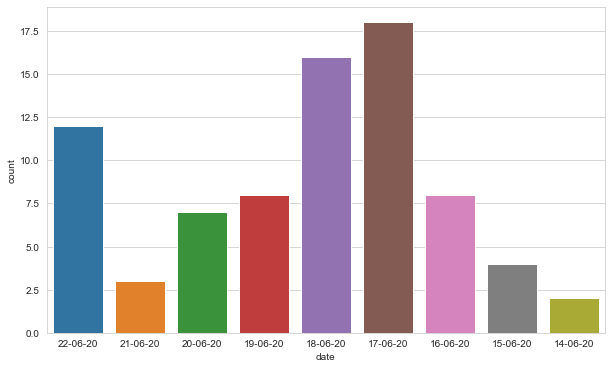

In [155]:
plt.figure(figsize=(10,6))
print("Tweets per day")
ax=sns.countplot(tweets['date'])

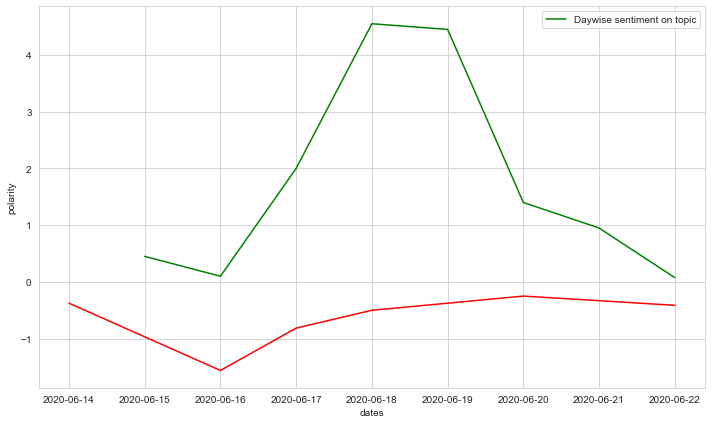

In [251]:
#Checking sentiment on day to day basis
plt.figure(figsize=(10,6))

daywise=pd.DataFrame(tweets[['date','sentiment','polarity']].groupby(['date','sentiment']).agg('sum').reset_index())
daywise['date']=pd.to_datetime(daywise['date'])
daywise_neg=daywise[daywise['sentiment']==1][['date','polarity']]
daywise_pos=daywise[daywise['sentiment']==0][['date','polarity']]

plt.plot(daywise_pos['date'],daywise_pos['polarity'],'g')
plt.legend(['Daywise sentiment on topic'])

plt.plot(daywise_neg['date'],daywise_neg['polarity'],'r')

plt.xlabel('dates')
plt.ylabel('polarity')

plt.tight_layout()

In [122]:
# lets see some negative tweets for a day that have high retweet count 
pd.options.display.max_colwidth = 200
tweets[(tweets['date']=='16-06-20') & (tweets['sentiment']==1) ].sort_values(by='retweet_count',ascending=False)['tweet']

64                        I found the statement of #GauravTaneja, pilot of #indigo, very pathetic situation of @indigo, the airline that play…
65    how to use #Goibibo credit shell ...need urgently... unable to use Goibibo credit...\n@goibibo @goibibo_tech @HMOIndia @IndiGo6E @indigo
Name: tweet, dtype: object

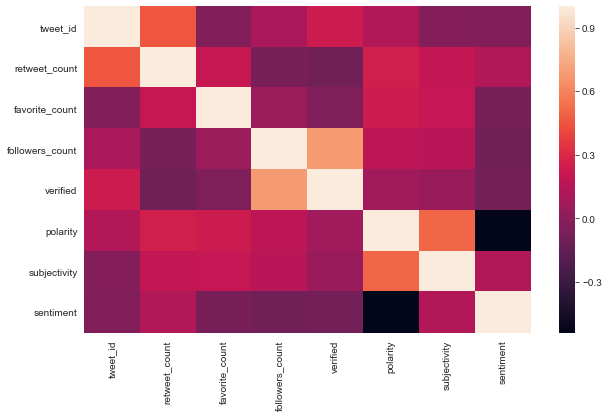

In [114]:
#Check for correlation
plt.figure(figsize=(10,6))
sns.heatmap(tweets.corr())

In [115]:
# User with most followers , what are they saying??

retweet_data=tweets.sort_values(by='followers_count',ascending=False)
mood = retweet_data.groupby('sentiment').agg('count')['tweet']

print('Positive tweets:',mood[0])
print('Negative tweets:',mood[1])

# So overall Positive sentiment on twitter
if mood[0]>mood[1]:
    print(":)")
else:
    print(":(")

Positive tweets: 61
Negative tweets: 18
:)


Hashtag with most tweet: fearlesswomen 


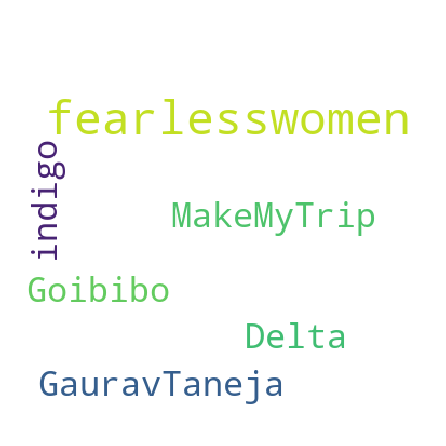

In [124]:
##  hashtags that have most retweets and trending, any +ve or -ve

tweets=tweets[tweets['hashtags']!='']
print('Hashtag with most tweet:',tweets.iloc[tweets['retweet_count'].max()]['hashtags'])

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(str(tweets['hashtags'].values))

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 

Hashtag with most Negative tweet: GauravTaneja indigo 


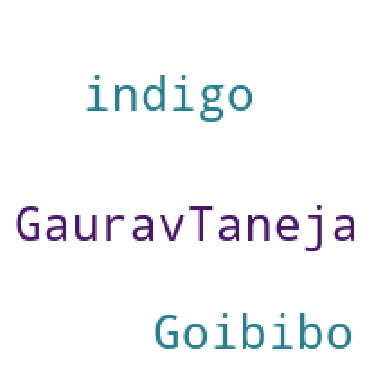

In [138]:
neg=tweets[tweets['sentiment']==1]
neg=neg[neg['hashtags']!='']
print('Hashtag with most Negative tweet:',neg.iloc[neg['retweet_count'].max()]['hashtags'])

wordcloud = WordCloud(width = 200, height = 200, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(str(neg['hashtags'].values))

# plot the WordCloud image                        
plt.figure(figsize = (5, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 

Hashtag with most Positive tweet: fearlesswomen 


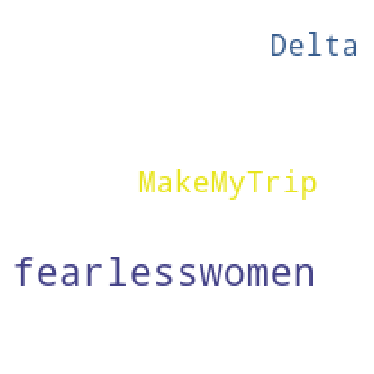

In [139]:
neg=tweets[tweets['sentiment']==0]
neg=neg[neg['hashtags']!='']
print('Hashtag with most Positive tweet:',neg.iloc[neg['retweet_count'].max()]['hashtags'])

wordcloud = WordCloud(width = 200, height = 200, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(str(neg['hashtags'].values))

# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 